# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

## Development
Start coding here! 🐱‍🏍

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

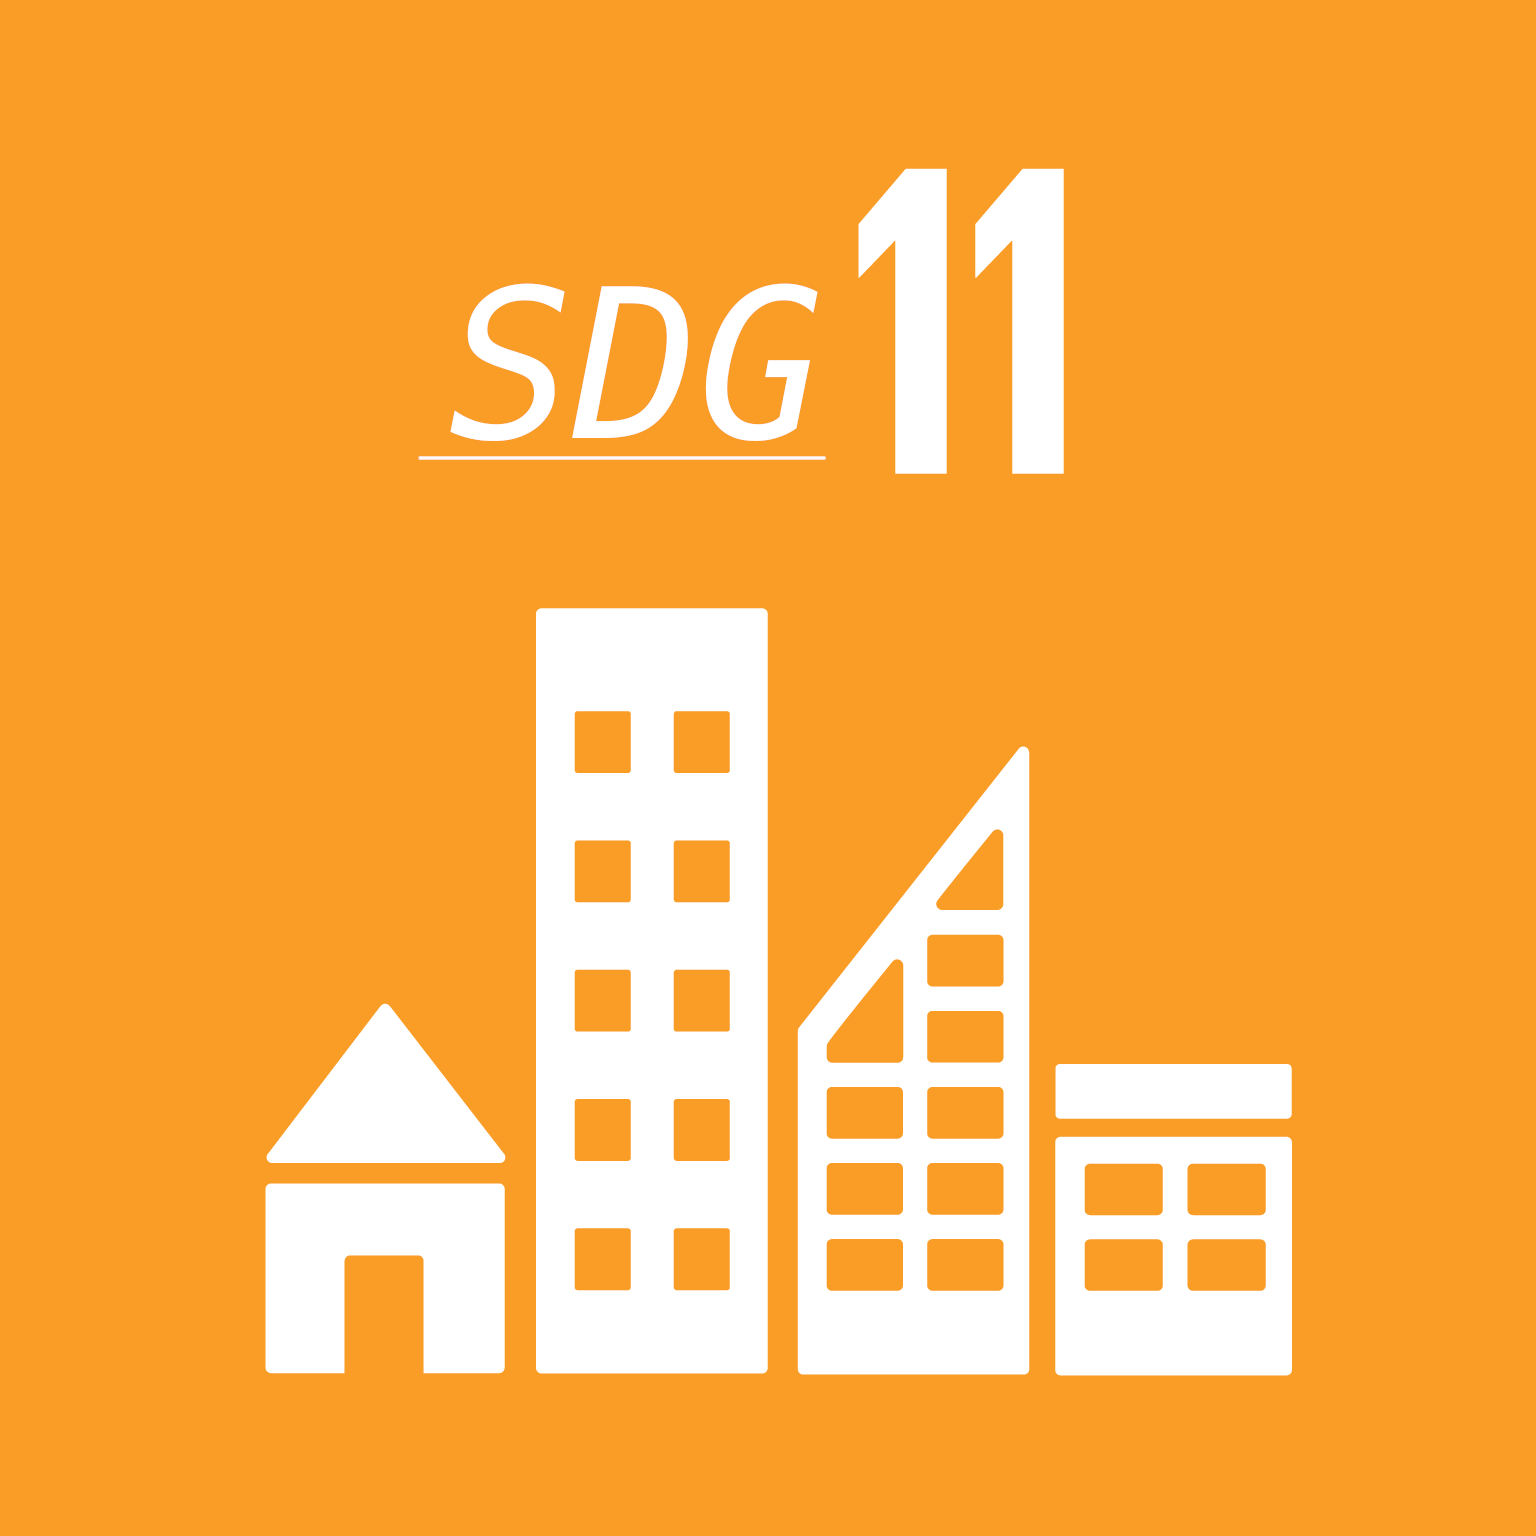

Load libs and datasets


In [58]:
#import libs
import pandas as pd
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
import urllib.request
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
#load processed dataset from repo  ########## RUN THIS ##############################################
#repo containing the external data and post-processed data: https://github.com/kylixalex/WDL_External_Data
print('Reading Data ....')
churn = StringIO(urllib.request.urlopen('https://raw.githubusercontent.com/kylixalex/WDL_External_Data/master/churn.txt').read().decode("iso-8859-1"))
churn = pd.read_csv(churn,sep='|',encoding='iso-8859-1')
print('Read Data Successfully !!!!')

Reading Data ....
Read Data Successfully !!!!


In [ ]:
# Load the Google Drive and mount
############################# team's internal use only: DO NOT RUN ###########################################################
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive/WDL".
# (previously you need to create WDL folder in your google drive and upload files into it)
!ls "/content/drive/My Drive/WDL"
##################################################################################
#path = "/content/drive/My Drive/WDL/" # change to your path/subfolders if needed, comment mine and add yours #Nuno
##################################################################################
path = "/content/drive/My Drive/WDL/Data/Churn/"  # Kylix
##################################################################################
#read raw data txt files
print('Reading Data ....')
churn_od = pd.read_csv(path + 'Churn_OD.txt', sep='|', encoding='iso-8859-1')
users_profile = pd.read_csv(path + 'Churn_UsersProfile.txt', sep='|', encoding='iso-8859-1',index_col = 'Period')
users_profile_raw = users_profile
female_county_age_raw = pd.read_excel(path + './PORDATA_estimates_county_gender_age.xlsx', sheet_name='Female')  # 'F county x age population'
male_county_age_raw = pd.read_excel(path + './PORDATA_estimates_county_gender_age.xlsx', sheet_name='Male')  # 'M county x age population'
print('Read Data Successfully !!!!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Churn model for public transports.pdf'
 Data
 Dictionaries
'Model of integrated transports for senior citizens.pdf'
Reading Data ....


FileNotFoundError: ignored

In [ ]:
# Data processing

# We want a file that looks like this:
# DISTRICT | COUNTY | AGE | %AVG_BUS_USERS_CHANGE | POP | COUNTY_POP | %COUNTY_POP |
############################# team's internal use only: DO NOT RUN ###########################################################

# Start processing and altering raw data
print('Processing Data...')
users_profile = users_profile_raw.drop(columns = ['Region_of_Origin']).reset_index() # Duplicate so that I can keep raw data as different variable, 'Region_of_Origin' irrelevant data as a whole

female_county_age = female_county_age_raw # Duplicate so that I can keep raw data as different variable
male_county_age = male_county_age_raw # Duplicate so that I can keep raw data as different variable

female_county_age['15-24'] = female_county_age['15-19'] + female_county_age['20-24']
female_county_age['25-34'] = female_county_age['25-29'] + female_county_age['30-34']
female_county_age['35-44'] = female_county_age['35-39'] + female_county_age['40-44']
female_county_age['45-54'] = female_county_age['45-49'] + female_county_age['50-54']
female_county_age['55-64'] = female_county_age['55-59'] + female_county_age['60-64']
male_county_age['15-24'] = male_county_age['15-19'] + male_county_age['20-24']
male_county_age['25-34'] = male_county_age['25-29'] + male_county_age['30-34']
male_county_age['35-44'] = male_county_age['35-39'] + male_county_age['40-44']
male_county_age['45-54'] = male_county_age['45-49'] + male_county_age['50-54']
male_county_age['55-64'] = male_county_age['55-59'] + male_county_age['60-64']

# Delete 5 by 5 agegroup columns
female_county_age = female_county_age.drop(columns=['15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64']) # To drop old AgeGroup columns, which didn't make sense with the AgeClassDescription we have in users_profile
male_county_age = male_county_age.drop(columns=['15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64'])

female_county_age = female_county_age.melt(id_vars=['GeoClass','GeoName','Total_Female'], value_vars=['15-24','25-34','35-44','45-54','55-64','65+']).rename(columns={"variable": "AgeClassDescription","value": "Pop", "GeoName": "County_of_Origin", "Total_Female": "Total_County_Pop"}).sort_values(by=['County_of_Origin', 'AgeClassDescription']) # This cleans up the data so as to turn it more workable

male_county_age = male_county_age.melt(id_vars=['GeoClass','GeoName','Total_Male'], value_vars=['15-24','25-34','35-44','45-54','55-64','65+']).rename(columns={"variable": "AgeClassDescription","value": "Pop", "GeoName": "County_of_Origin","Total_Male": "Total_County_Pop"}).sort_values(by=['County_of_Origin', 'AgeClassDescription']) # This cleans up the data so as to turn it more workable

male_county_age['GenderDescription']='Male' # Create new column GenderDescription and assign it to 'Male' for all rows
female_county_age['GenderDescription']='Female' # Create new column GenderDescription and assign it to 'Female' for all rows

county_age = pd.concat([female_county_age, male_county_age]).drop(columns = ['GeoClass'])# Add the female and male lists together
county_age = county_age[['County_of_Origin','AgeClassDescription','GenderDescription','Total_County_Pop','Pop']] # Personal preference

county_age = users_profile.merge(county_age, on=["County_of_Origin","AgeClassDescription","GenderDescription"]) # Join population data set with churn data set

#########
value_sum = county_age.groupby(['District_of_Origin','County_of_Origin','Period','AgeClassDescription'],as_index=False)['Pop'].sum().reset_index().rename(columns={"Pop": "County_Age_Pop"})
value_sum['County_Pop'] = county_age.groupby(['District_of_Origin','County_of_Origin','Period','AgeClassDescription'],as_index=False)['Total_County_Pop'].sum().reset_index().rename(columns={"Pop": "County_Age_Pop"})['Total_County_Pop']
county_age = county_age.merge(value_sum, on=["District_of_Origin","County_of_Origin","Period","AgeClassDescription"]).drop(columns=['index'])

county_age['Avg_not_summed_yet'] = county_age['Pop'] / county_age['County_Age_Pop'] * county_age['Average_BusUsers_per_Day']

value_sum = county_age.groupby(['District_of_Origin','County_of_Origin','Period','AgeClassDescription'],as_index=False)['Avg_not_summed_yet'].sum().reset_index().rename(columns={"Pop": "County_Age_Pop"})

county_age = county_age.merge(value_sum, on=["District_of_Origin","County_of_Origin","Period","AgeClassDescription"]).drop(columns=['index', 'Average_BusUsers_per_Day','Avg_not_summed_yet_x','Pop','Total_County_Pop']).rename(columns={"Avg_not_summed_yet_y": "Average_BusUsers_per_Day"})

county_age = county_age.drop(columns=['GenderDescription']).drop_duplicates().rename(columns={"County_Age_Pop": "Total_County_Age_Pop","County_Pop":"Total_County_Pop"})

county_age['%County_Age_Pop'] = county_age['Total_County_Age_Pop'] / county_age['Total_County_Pop'] * 100

listof = []
for i in range(146):
    listof.append(1)
    listof.append(-1)
listof.append(1)
county_age['value'] = listof
county_age['Average_BusUsers_per_Day'] = county_age['Average_BusUsers_per_Day'] * county_age['value']
county_age = county_age.drop(columns=['value'])

value_sum = county_age.groupby(['District_of_Origin','County_of_Origin','AgeClassDescription'],as_index=False)['Average_BusUsers_per_Day'].sum().reset_index()
county_age = county_age.merge(value_sum, on=["District_of_Origin","County_of_Origin","AgeClassDescription"]).drop(columns=['index','Period']).rename(columns={"Average_BusUsers_per_Day_y": "Average_BusUsers_per_Day"}).drop_duplicates()

county_age['Average_BusUsers_per_Day'] /= county_age['Average_BusUsers_per_Day_x']/100
county_age = county_age.rename(columns={"Average_BusUsers_per_Day": "%Average_BusUsers_per_Day_CHANGE"})
county_age = county_age.loc[(county_age["Average_BusUsers_per_Day_x"]>=0)].drop(columns="Average_BusUsers_per_Day_x") 

print("Finished Processing Data...") # Another checkpoint

Processing Data...
Finished Processing Data...


###Feature Engineering + EDA + 


In [ ]:
# Checking for NAN values
print(churn_od.isna().sum())
print(churn_od.dtypes)

Region_of_Origin                               0
District_of_Origin                             0
County_of_Origin                               0
Region_of_Public_Transportation                0
District_of_Public_Transportation              0
County_of_Public_Transportation                0
Dicofre_ParishCode_of_Public_Transportation    0
Demand_weight                                  0
dtype: int64
Region_of_Origin                                object
District_of_Origin                              object
County_of_Origin                                object
Region_of_Public_Transportation                 object
District_of_Public_Transportation               object
County_of_Public_Transportation                 object
Dicofre_ParishCode_of_Public_Transportation      int64
Demand_weight                                  float64
dtype: object


In [ ]:
print ("The length of the dataframe churn_od is :" , str(len(churn_od)))

The length of the dataframe churn_od is : 2253


In [ ]:
#churn OD feature engineering
od = churn_od
county = od['County_of_Origin'].unique().tolist()

#describe destination parish by county
od_describe = od.groupby(['County_of_Origin'],as_index=False).describe()
#od_describe = od_count.iloc[:,5:10]
od_describe = od_describe['Demand_weight']
od_describe.columns = ['dest_demand_' + sub for sub in od_describe.columns]
od_describe['County_of_Origin'] = county
churn = churn.merge(od_describe, on=["County_of_Origin"])
#od_describe

print("Writing Data File")

churn.to_csv(path + './churn.txt', encoding='iso-8859-1', sep='|', index=False) # Writing a txt to visually represent the dataframe at hand

print("Done!")

Writing Data File
Done!


In [ ]:
# Checking for NAN values
users_profile.isna().sum()

Region_of_Origin            0
District_of_Origin          0
County_of_Origin            0
GenderDescription           0
AgeClassDescription         0
Average_BusUsers_per_Day    0
dtype: int64

In [ ]:
print ("The length of the dataframe users_profile is :" , str(len(users_profile)))

The length of the dataframe users_profile is : 544


In [ ]:
users_profile

,Region_of_Origin,District_of_Origin,County_of_Origin,GenderDescription,AgeClassDescription,Average_BusUsers_per_Day
Period,,,,,,
Sep-19 to Feb-20,R1 - AM Lisboa,Lisboa,Amadora,Female,15-24,294.194206
Sep-19 to Feb-20,R1 - AM Lisboa,Lisboa,Amadora,Female,25-34,1081.652817
Sep-19 to Feb-20,R1 - AM Lisboa,Lisboa,Amadora,Female,35-44,235.836653
Sep-19 to Feb-20,R1 - AM Lisboa,Lisboa,Amadora,Female,45-54,840.951323
Sep-19 to Feb-20,R1 - AM Lisboa,Lisboa,Amadora,Female,55-64,1216.148092
...,...,...,...,...,...,...
Sep-20 to Jan-21,R2 - AM Porto,Porto,Vila Nova de Gaia,Male,15-24,4452.188395
Sep-20 to Jan-21,R2 - AM Porto,Porto,Vila Nova de Gaia,Male,25-34,363.461965
Sep-20 to Jan-21,R2 - AM Porto,Porto,Vila Nova de Gaia,Male,35-44,214.023515


In [ ]:
aggProfiles = users_profile.groupby(["Region_of_Origin",'District_of_Origin','County_of_Origin','Period','AgeClassDescription'],as_index=False).sum()
aggProfiles

,Region_of_Origin,District_of_Origin,County_of_Origin,AgeClassDescription,Average_BusUsers_per_Day
0,R1 - AM Lisboa,Lisboa,Amadora,15-24,1442.621257
1,R1 - AM Lisboa,Lisboa,Amadora,25-34,1503.592997
2,R1 - AM Lisboa,Lisboa,Amadora,35-44,373.534260
3,R1 - AM Lisboa,Lisboa,Amadora,45-54,1458.644484
4,R1 - AM Lisboa,Lisboa,Amadora,55-64,2083.630005
...,...,...,...,...,...
313,R2 - AM Porto,Porto,Vila do Conde,45-54,76.945089
314,R2 - AM Porto,Porto,Vila do Conde,25-34,296.497519
315,R2 - AM Porto,Porto,Vila do Conde,35-44,27.734416
316,R2 - AM Porto,Porto,Vila do Conde,45-54,76.844212


In [ ]:
print ("There are " + str(len(counties)) + " different counties.")

There are 35 different counties.


In [ ]:
# converted the %Average_BusUsers_per_Day_CHANGE into categorical variable to check whether the change is Rise or Drop.
pcgap['BusUser_Drop/rise'] = pcgap['%Average_BusUsers_per_Day_CHANGE'].apply(lambda x:'D' if x<0 else 'R')

In [ ]:
pcgap

,District_of_Origin,County_of_Origin,GenderDescription,AgeClassDescription,%Average_BusUsers_per_Day_CHANGE,BusUser_Drop/rise
0,Lisboa,Amadora,Female,15-24,82.194334,R
1,Lisboa,Amadora,Female,25-34,-62.273631,D
2,Lisboa,Amadora,Female,35-44,102.825636,R
3,Lisboa,Amadora,Female,45-54,-32.077779,D
4,Lisboa,Amadora,Female,55-64,-39.063970,D
...,...,...,...,...,...,...
234,Porto,Vila Nova de Gaia,Male,15-24,-15.046232,D
235,Porto,Vila Nova de Gaia,Male,25-34,28.551482,R
236,Porto,Vila Nova de Gaia,Male,35-44,-75.777066,D
237,Porto,Vila Nova de Gaia,Male,45-54,-19.293506,D


In [ ]:
pcgap['%Average_BusUsers_per_Day_CHANGE'].max()

4227.424965299631

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c65876650>]],
      dtype=object)

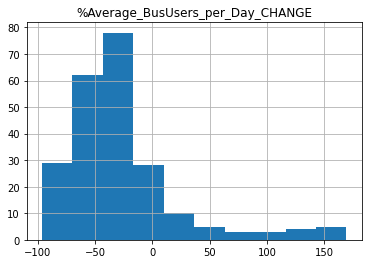

In [ ]:
pcgap[pcgap['%Average_BusUsers_per_Day_CHANGE']<200].hist()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c657bf5d0>,
      dtype=object)

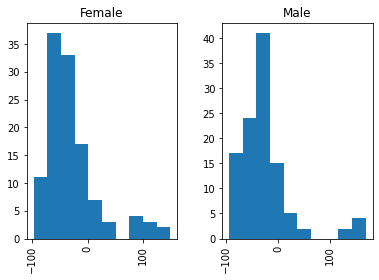

In [ ]:
pcgap[pcgap['%Average_BusUsers_per_Day_CHANGE']<200].hist(by=pcgap['GenderDescription'])

genders' hist doesn't seem different --> let's drop gender as a feature and merge related values at county level by age class using weighted avg


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c65227550>,
      dtype=object)

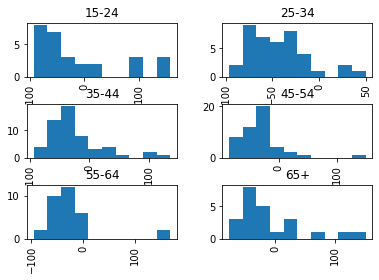

In [ ]:
#
pcgap[pcgap['%Average_BusUsers_per_Day_CHANGE']<200].hist(by=pcgap['AgeClassDescription'])

age class's hist suggest differences between age classs

In [ ]:
# changed other categorical variable into dummies to help in next process
dummy1 = pd.get_dummies(pcgap['County_of_Origin'],drop_first=True)
dummy2 = pd.get_dummies(pcgap['GenderDescription'],drop_first=True)
dummy3 = pd.get_dummies(pcgap['AgeClassDescription'],drop_first=True)

In [ ]:
#drop all the categorical variable from which we have got the dummies
pcgap = pcgap.drop(['County_of_Origin','GenderDescription','AgeClassDescription'], axis=1)

In [ ]:
#concatenated the dummies with dataframe to get new dataframe.
pcgap_new = pd.concat([pcgap,dummy1,dummy2,dummy3],axis=1)

In [ ]:
pcgap_new.columns

Index(['District_of_Origin', '%Average_BusUsers_per_Day_CHANGE',
       'BusUser_Drop/rise', 'Almada', 'Amadora', 'Barreiro', 'Cascais',
       'Espinho', 'Gondomar', 'Lisboa', 'Loures', 'Mafra', 'Maia',
       'Matosinhos', 'Moita', 'Montijo', 'Odivelas', 'Oeiras',
       'Oliveira de Azemï¿½is', 'Palmela', 'Paredes', 'Porto',
       'Pï¿½voa de Varzim', 'Santa Maria da Feira', 'Santo Tirso', 'Seixal',
       'Sesimbra', 'Setï¿½bal', 'Sintra', 'Trofa', 'Valongo',
       'Vila Franca de Xira', 'Vila Nova de Gaia', 'Vila do Conde', 'Male',
       '25-34', '35-44', '45-54', '55-64', '65+'],
      dtype='object')

###Churn model

In [ ]:
print(churn.dtypes)
churn = churn.drop('District_of_Origin', axis=1)
churn = churn.drop('County_of_Origin', axis=1)
churn = pd.get_dummies(churn, drop_first=True)
print(churn.dtypes)

District_of_Origin                   object
County_of_Origin                     object
AgeClassDescription                  object
Total_County_Age_Pop                  int64
Total_County_Pop                      int64
%County_Age_Pop                     float64
%Average_BusUsers_per_Day_CHANGE    float64
dest_demand_count                   float64
dest_demand_mean                    float64
dest_demand_std                     float64
dest_demand_min                     float64
dest_demand_25%                     float64
dest_demand_50%                     float64
dest_demand_75%                     float64
dest_demand_max                     float64
dtype: object
Total_County_Age_Pop                  int64
Total_County_Pop                      int64
%County_Age_Pop                     float64
%Average_BusUsers_per_Day_CHANGE    float64
dest_demand_count                   float64
dest_demand_mean                    float64
dest_demand_std                     float64
dest_demand_min   

Train/test split

target distribution

train data
AxesSubplot(0.125,0.125;0.775x0.755)

test data
AxesSubplot(0.125,0.125;0.775x0.755)


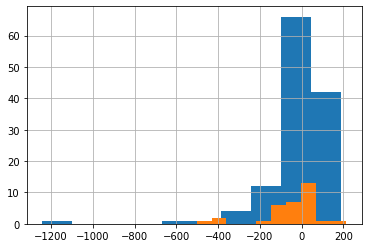

In [ ]:
#isolate target variable y
X = churn.drop('%Average_BusUsers_per_Day_CHANGE', axis=1)
Y = churn['%Average_BusUsers_per_Day_CHANGE']

#train/test split
seed = 2021
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2,random_state=seed)

print('target distribution\n')
print('train data')
print(Y_train.hist())
print('')
print('test data')
print(Y_test.hist())

Models and 10-fold CV evaluation

[('CART', DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')), ('RF', RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False))]
CART: -30422.784608 (37276.989462)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: -28971.000123 (33695.904106)


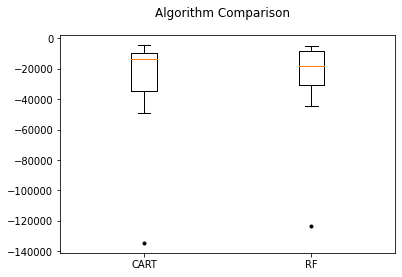

In [49]:
seed = 2021
scoring = 'neg_mean_squared_error'

#models' list
models = []
models.append(('CART', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor(max_depth=5)))
print(models)

#model evaluation using 10-fold CV
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
  
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results,sym='k.')
ax.set_xticklabels(names)
plt.show()

#https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

the decision tree

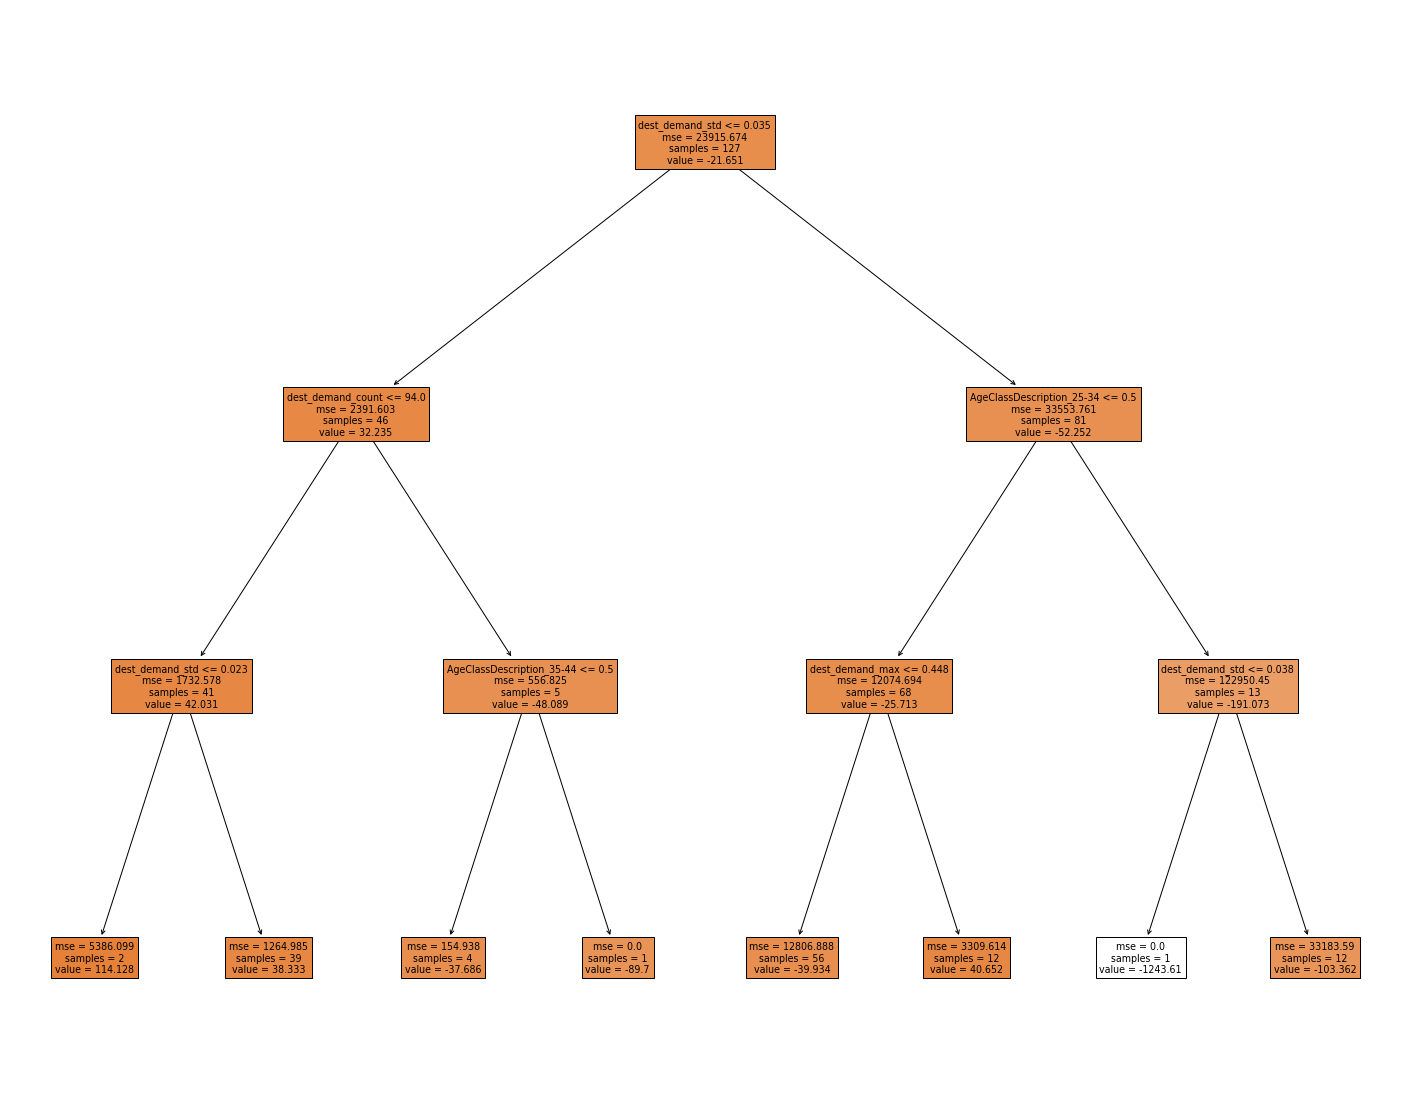

In [64]:
regr = DecisionTreeRegressor(max_depth=3, random_state=1234)
model = regr.fit(X_train, Y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, feature_names=X_train.columns, filled=True)

## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀